<h1 style="font-size:2em;">TITANIC</h1>

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

`INFO ABOUT DATA`

There are two similar datasets that include passenger information like name, age, gender, socio-economic class, etc. One dataset is titled train.csv and the other is titled test.csv.

Train.csv will contain the details of a subset of the passengers on board (891 to be exact) and importantly, will reveal whether they survived or not, also known as the “ground truth”. So 1 means that person survived and 0 means that person did not survived.

The test.csv dataset contains similar information but does not disclose the “ground truth” for each passenger. It’s your job to predict these outcomes.

In [27]:
#Importing the libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from plotly.subplots import make_subplots
import plotly.graph_objects as go
palette = ['#186F65','#B5CB99','#79AC78','#618264']
color_palette = sns.color_palette(palette)
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)
# plt.rc("font", size=14)
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

`DATA UNDERSTANDING AND EXPLORATION`

In [2]:
#Loading the data
train = pd.read_csv("/Users/sultanbeishenkulov/Programming/Projects/kaggle/titanic/train.csv")
test = pd.read_csv("/Users/sultanbeishenkulov/Programming/Projects/kaggle/titanic/test.csv")
train.columns = map(str.lower, train.columns)
test.columns = map(str.lower, test.columns)
train.head(7)

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S


In [3]:
#Checking dublicates 
print('duplicates in train set: {}, duplicates in test set: {}'.format(train.duplicated().sum(), test.duplicated().sum()))

duplicates in train set: 0, duplicates in test set: 0


missing values in train set: passengerid      0
survived         0
pclass           0
name             0
sex              0
age            177
sibsp            0
parch            0
ticket           0
fare             0
cabin          687
embarked         2
dtype: int64


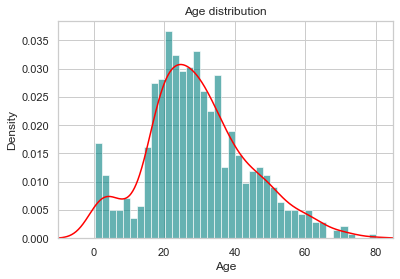

mean: 29.7 	 median: 28.0


In [4]:
#MISSING VALUES
print('missing values in train set: {}'.format(train.isnull().sum()))
#AGE
ax = train['age'].hist(bins=40, density=True, stacked = True, color='teal',alpha=0.6)
train['age'].plot(kind='density', color= 'red')
ax.set(xlabel= 'Age')
plt.xlim(-10,85)
plt.title('Age distribution')
plt.show()

print('mean: {} \t median: {}'.format(round(train['age'].mean(skipna=True),2), train['age'].median(skipna=True)))
#we see that age distribution is right skewed meaning that by using mean for ms imputing we might present bias therefore we gonna use median

In [5]:
#Cabin
cabin_ms = round(train['cabin'].isnull().sum()/train.shape[0] * 100, 2)
print('Percent of missing "Cabin" records is {}% '.format(cabin_ms))
# 77% is too much therefore we gonna ignore this feature 

Percent of missing "Cabin" records is 77.1% 


Percent of missing "Embarked" records is 0.22% 
Boarded passengers grouped by port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton):
S    644
C    168
Q     77
Name: embarked, dtype: int64


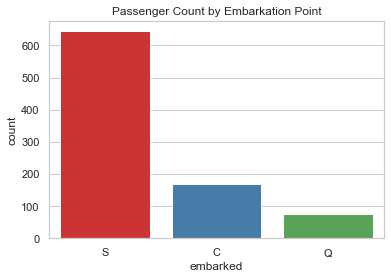

In [6]:
#Embarked
cabin_ms = round(train['embarked'].isnull().sum()/train.shape[0] * 100, 2)
print('Percent of missing "Embarked" records is {}% '.format(cabin_ms))
# Let's plot it:
print('Boarded passengers grouped by port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton):')
print(train['embarked'].value_counts())
sns.countplot(x='embarked', data=train, palette='Set1')
plt.title('Passenger Count by Embarkation Point')
plt.show()

In [7]:
#Checking the ratio of survived man vs woman
train[(train['survived']==1) & (train['sex']=="female")]['sex'].count()/len(train)

print('ratio between survived men and women is: men: {} and women: {}'.format(round(1-train[(train['survived']==1) & (train['sex']=="female")]['sex'].count()/len(train), 2), round(train[(train['survived']==1) & (train['sex']=="female")]['sex'].count()/len(train),2)))

ratio between survived men and women is: men: 0.74 and women: 0.26


In [8]:
#checking percentage of men and women survived
man = train.loc[train.sex =='male']['survived']
woman = train.loc[train.sex =='female']['survived']
print('Out of {} men only {}% survived \n out of {}  women  {}% survived'.format(sum(man), round((sum(man)/len(man)*100),2), sum(woman), round((sum(woman)/len(woman)*100),2)))

Out of 109 men only 18.89% survived 
 out of 233  women  74.2% survived


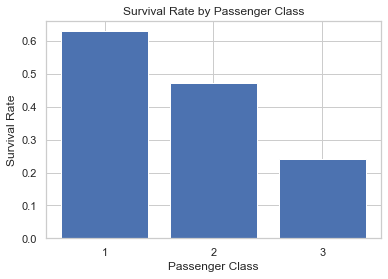

In [9]:
# Grouping by passenger class and calculating the survival rate for each class
survival_by_class = train.groupby('pclass')['survived'].mean()

# Plotting the survival rate for each class
plt.bar(survival_by_class.index, survival_by_class.values)
plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate')
plt.title('Survival Rate by Passenger Class')
plt.xticks([1, 2, 3])  # Setting x-ticks to display passenger class numbers
plt.show()

#We clearly can see the correlation between passenger class and surviving rate

`DATA PREPROCESSING AND FEATURE ENGINEERING`

In [17]:
#imputing missing values with respective ones discussed above to new train_data dataframe
# train_data = train.copy()
train["age"].fillna(train["age"].median(skipna=True), inplace=True)
train["embarked"].fillna(train['embarked'].value_counts().idxmax(), inplace=True)
train.drop('cabin', axis=1, inplace=True)

#test
# test_data = test.copy()
test["age"].fillna(train["age"].median(skipna=True), inplace=True)
test.drop('cabin', axis=1, inplace=True)
test.dropna(subset=['fare'], inplace=True)

In [18]:
# Family Size (adding 1 for the person itself)
train['familysize'] = train['sibsp'] + train['parch'] + 1
test['familysize'] = test['sibsp'] + test['parch'] + 1

# Title
train['title'] = train['name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test['title'] = test['name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# IsAlone
train['is_alone'] = (train['familysize'] == 1).astype(int)
test['is_alone'] = (test['familysize'] == 1).astype(int)

# Age Group
train['age_group'] = pd.cut(train['age'], bins=[0-10, 18, 30, 50, 100], labels=['child', 'young_adult', 'adult', 'elderly'])
test['age_group'] = pd.cut(test['age'], bins=[0-10, 18, 30, 50, 100], labels=['child', 'young_adult', 'adult', 'elderly'])

# Fare per Person
train['fare_per_person'] = train['fare'] / train['familysize']
test['fare_per_person'] = test['fare'] / test['familysize']

# Ticket Frequency
ticket_counts = train['ticket'].value_counts()
train['ticketfrequency'] = train['ticket'].apply(lambda x: ticket_counts[x])

ticket_counts_test = test['ticket'].value_counts()
test['ticketfrequency'] = test['ticket'].apply(lambda x: ticket_counts_test[x])

# Age * Class
train['age*class'] = train['age'] * train['pclass']
train['age*class'] = train['age'] * train['pclass']

In [19]:
train.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked,familysize,title,is_alone,age_group,fare_per_person,ticketfrequency,age*class
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,2,2,Mr,0,young_adult,3.62500,1,66.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,0,2,Mrs,0,adult,35.64165,1,38.0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,2,1,Miss,1,young_adult,7.92500,1,78.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,2,Mrs,0,adult,26.55000,2,35.0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,2,1,Mr,1,adult,8.05000,1,105.0


In [20]:
#Encoding categorical features
Categorical_cols = ['sex', 'embarked', 'title', 'age_group']
le = LabelEncoder()
for col in Categorical_cols:    
    train[col] = le.fit_transform(train[[col]])


In [ ]:
#Detecting outliers and dealing with them
#let's check all the continious variables
# Num _COLS 
NUM_COLS_F = [col for col in train.columns if train[col].dtype == 'float']

# BoxPLot To Identify Outliers
fig = go.Figure()   
# Sub Plots
fig = make_subplots(rows=2, cols=2, subplot_titles=NUM_COLS_F)

# Loop through each row of subplots
for i in range(2):
    # Loop through each subplot in the row
    for j in range(2):
        # Calculate the index of the current numerical column
        index = i * 2 + j
        # Check if the index is within the range of available numerical columns
        if index < len(NUM_COLS_F):
            # Add a box plot for the current numerical column to the subplot
            fig.add_trace(go.Box(x=train[NUM_COLS_F[index]], name=NUM_COLS_F[index], marker_color=palette[index]), row=i + 1, col=j + 1)

# Update layout
fig.update_layout(height=600, width=1000, title_text="Boxplot of Numerical Columns")

# Show the plot
fig.show()

In [ ]:
# # Cols to Plot
# NUM_COLS_F = [col for col in train.columns if train[col].dtype == 'float']
# # Numerical Distribution of Age Vs Fare
# plot_numerical_distribution_with_hue(train,NUM_COLS_F,'Survived')

`Model Selection and Training`

`Model Evaluation and Validation`

`Hyperparameter Tuning and Optimization`

`Result Analysis`